## Ground-state preparation for TF Ising Model using QETU

Based on methodology from [arXiv:2204.05955](https://arxiv.org/abs/2204.05955)

The Hamiltonian that will be implemented is given by the following equation:

$$H_{\mathrm{TFIM}}=\underbrace{-\sum_{j=1}^{n-1}Z_{j}Z_{j+1}}_{H_{\mathrm{TFIM}}^{(1)}}\underbrace{-g\sum_{j=1}^{n}X_{j}}_{H_{\mathrm{TFIM}}^{(2)}}.$$
The Trotterized implementation of the Hamiltonian typically includes controlled operations for Hamiltonian components. In this case, the implementation is modified in such a way as to avoid this by implementing Pauli strings $K$. The strings are selected to anticommute with each grouped Hamiltonian term. In the TFIM case we can identify one String to commute with all terms:
$$K:=Y_1\otimes Z_2\otimes Y_3\otimes Z_4\otimes\cdots . $$
This can be implemented on cirq using the following function:

In [2]:
import cirq as cirq
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [3]:
def K(q,n_qubits):
    if n_qubits % 2:
          raise Exception("Sorry, numbers of qubits must be even") 

    # q = cirq.LineQubit.range(n_qubits)
    seq = []
    for i in range(int(n_qubits/2)):
        seq.append([cirq.Y(q[i]),cirq.Z(q[i+1])])
    return cirq.PauliString(seq)


Alongside our only Pauli string we must define out evolution operator $W$.

In [4]:
def rzz(rads,q,i):
    """Returns a gate with the matrix exp(-i Z⊗Z rads)."""
    return cirq.ZZPowGate(exponent=2 * rads / np.pi, global_shift=-0.5,).on(q[i],q[i+1])


def W(q,n_qubits,tau,steps):
    g = 4
    # q = cirq.LineQubit.range(n_qubits)
    W = cirq.Circuit()
    t = tau/steps
    for j in range(steps):
        # H_1:
        for i in range(n_qubits-1):
            W.append(rzz(-t,q,i))
        # H_2:
        for i in range(n_qubits):
            W.append(cirq.rx(-2*g*t).on(q[i]))
        
    return W


In [5]:
def KWK_step(q,n_qubits,tau,steps):
    # q = cirq.LineQubit.range(n_qubits+1) #last qubit selected as ancilla
    KWK_step = cirq.Circuit()
    KWK_step.append(cirq.X(q[-1]))
    KWK_step.append(K(q,n_qubits).controlled_by(q[-1],control_values=[1]))
    KWK_step.append(cirq.X(q[-1]))
    KWK_step.append(W(q,n_qubits,tau,steps))
    KWK_step.append(cirq.X(q[-1]))
    KWK_step.append(K(q,n_qubits).controlled_by(q[-1],control_values=[1]))
    KWK_step.append(cirq.X(q[-1]))
    return KWK_step


The complete circuit intersperses KWK operations with $e^{i\phi_i X}$ terms, where $\phi_i$ refers to adjustable phase factor parameters from the polynomial approximation of the shifted sign function. Thus we need to construct the polynomials via optimization. In this case the method used is Convex Optimization. We start off by witing out our $d$ degree target polynomial as a LC of Chebyshev polynomials $T_{2k}$:
$$F(x) = \sum_{k=0}^{d/2} T_{2k}(x) c_k $$
with unknown parameters $c_k$. Then we generate a matrix of coefficients $A_{jk}$ by discretizing the domain over Chevbyshev root values.



In [6]:
def shifted_sign_function(x,mu):
    func = abs(np.heaviside(x-mu*np.ones(len(x)),0))
    return func

def sigma(string,mu,delta,eta):
    if string == '+':
        return np.cos((mu-delta/2)/2)
    if string == '-':
        return np.cos((mu+delta/2)/2)
    if string == 'min':
        return np.cos((np.pi-eta)/2)
    if string == 'max':
        return np.cos(eta/2)
    else: 
        raise 'Invalid string input'

Once we have the values for the phases that will be applied to the ancilla we can implement the QETU circuit.

In [7]:
def QETU_circuit(q,n_qubits,phases,steps):
    QETU_circuit = cirq.Circuit()
    tau = 0.5
    for i in range(int(len(phases)/2)):
        QETU_circuit.append(np.exp(1j*phases[2*i]*cirq.X(q[-1])))
        QETU_circuit.append(KWK_step(q,n_qubits,tau,steps))
        QETU_circuit.append(np.exp(1j*phases[2*i+1]*cirq.X(q[-1])))
        QETU_circuit.append(cirq.X(q[-1]))
        QETU_circuit.append(KWK_step(q,n_qubits,tau,steps))
        QETU_circuit.append(cirq.X(q[-1]))
    if int(len(phases)/2)== 0:
        QETU_circuit.append(np.exp(1j*phases[0]*cirq.X(q[-1])))
        QETU_circuit.append(KWK_step(q,n_qubits,tau,steps))

    QETU_circuit.append(cirq.M(q[-1]))
    return QETU_circuit


In [8]:
def H_observable(q,n_qubits):
    op = 0
    g = 4

    for i in range(n_qubits-1):
        op += -1*cirq.Z(q[i])*cirq.Z(q[i+1])
    for i in range(n_qubits):
        op += -1*g*cirq.X(q[i])
    # op += 0*cirq.I(q[-1])
    return op

In [9]:
X1 = np.array([[0,1],[1,0]])
Z1 = np.array([[1,0],[0,-1]])

def Z_q(qubit,n_qubits):
    Z = 1
    for i in range(0,n_qubits):
        if i in qubit:
            mat=Z1
        else: 
            mat=np.identity(2)
        Z = np.kron(Z,mat)
    return Z



def X_q(qubit,n_qubits):
    X = 1
    for i in range(0,n_qubits):
        if i in qubit:
            mat=X1
        else: 
            mat=np.identity(2)
        X = np.kron(X,mat)
    return X

def H_operator(n_qubits):
    op = np.zeros([2**n_qubits,2**n_qubits])
    g = 4

    for i in range(n_qubits-1):
        op += -1*Z_q([i,i+1],n_qubits)
    for i in range(n_qubits):
        op += -1*g*X_q([i],n_qubits)
    return op

def H_sh_operator(n_qubits):
    op = np.zeros([2**n_qubits,2**n_qubits])
    g = 4
    eta = 0.1

    ordered_eigenvals  = np.sort(np.linalg.eigvals(H_operator(n_qubits)))
    E_0 = ordered_eigenvals[0]
    c1 = (np.pi - 2*eta)/(ordered_eigenvals[-1]-ordered_eigenvals[0])
    c2 = eta - c1*ordered_eigenvals[0]

    for i in range(n_qubits-1):
        op += -1*Z_q([i,i+1],n_qubits)
    for i in range(n_qubits):
        op += -1*g*X_q([i],n_qubits)

    op_sh = op*c1 + np.identity(2**n_qubits)*c2
    return op_sh, c1, c2, E_0

def produce_case_parameters(n_qubits):
    ordered_eigenvals_sh  = np.sort(np.linalg.eigvals(H_sh_operator(n_qubits)[0]))
    E_0 = H_sh_operator(n_qubits)[3]
    c1 = H_sh_operator(n_qubits)[1]
    c2 = H_sh_operator(n_qubits)[2]
    mu = (ordered_eigenvals_sh[0] + ordered_eigenvals_sh[1])/2
    delta = ordered_eigenvals_sh[1] - ordered_eigenvals_sh[0]
    return mu, delta, c1 , c2, E_0


In [10]:
M = 400
c = 0.999
eta = 0.1

def get_coef_matrix(x_j,d):
    #we want to discretize on the roots (M values)
    A = np.polynomial.chebyshev.chebvander(x_j,d-1) #default domain is [-1,1] which is what we need
    for i in range(int(d/2)):
        A[:,2*i+1]=np.zeros(len(x_j))
    return A

def poly_coef(d, n_qubits):
    coefs = cp.Variable(d)
    j = np.linspace(0,M-1,M) 
    x_j = -np.cos(j*np.pi/(M-1))
    A = get_coef_matrix(x_j,d)
    F_xj = cp.matmul(A,coefs)

    mu, delta, c1, c2, E0 = produce_case_parameters(n_qubits)

    sigma_plus = sigma('+', mu, delta, eta)
    sigma_max = sigma('max', mu, delta, eta)
    sigma_minus = sigma('-', mu, delta, eta)
    sigma_min = sigma('min', mu, delta, eta)

    x_j1 = []
    x_j2 = []

    for x in x_j:
        if x >= sigma_plus and x <= sigma_max:
            x_j1.append(x)
        if x <= sigma_minus and x >= sigma_min:
            x_j2.append(x)
    
    if x_j1==[]:
        x_j1 = [sigma_plus]
   
    A1 = get_coef_matrix(x_j1,d)
    F_xj1 = cp.matmul(A1,coefs)
    T1 = cp.abs(F_xj1-c)
    max_1 = cp.max(T1)

    if x_j2==[]:
        x_j2 = [sigma_minus]
    
    A2 = get_coef_matrix(x_j2,d)
    F_xj2 = cp.matmul(A2,coefs)
    T2 = cp.abs(F_xj2)
    max_2 = cp.max(T2)

    targ = cp.maximum(max_1,max_2)

    objective = cp.Minimize(targ)
    constraint = [cp.abs(F_xj)<=c]
    prob = cp.Problem(objective, constraint)

    result = prob.solve()
    # x = np.linspace(0,1,M)
    # y = np.polynomial.chebyshev.chebval(x, coefs.value)
    # plt.plot(x,y,'.')
    return coefs.value
   

In [11]:
# #Example
# d = 20
# n_qubits = 4
# mu = 1
# delta = 0.4
# coefs = cp.Variable(d+1)
# j = np.linspace(0,M-1,M) 
# x_j = -np.cos(j*np.pi/(M-1))
# A = get_coef_matrix(x_j,d)
# F_xj = cp.matmul(A,coefs)

# sigma_plus = sigma('+', mu, delta, eta)
# sigma_max = sigma('max', mu, delta, eta)
# sigma_minus = sigma('-', mu, delta, eta)
# sigma_min = sigma('min', mu, delta, eta)

# x_j1 = []
# x_j2 = []

# for x in x_j:
#     if x >= sigma_plus and x <= sigma_max:
#         x_j1.append(x)
#     if x <= sigma_minus and x >= sigma_min:
#         x_j2.append(x)

# if x_j1==[]:
#     x_j1 = [sigma_plus]

# A1 = get_coef_matrix(x_j1,d)
# F_xj1 = cp.matmul(A1,coefs)
# T1=cp.abs(F_xj1-c)
# max_1 = cp.max(T1)

# if x_j2==[]:
#     x_j2 = [sigma_minus]

# A2 = get_coef_matrix(x_j2,d)
# F_xj2 = cp.matmul(A2,coefs)
# T2=cp.abs(F_xj2)
# max_2 = cp.max(T2)

# targ = cp.maximum(max_1,max_2)

# objective = cp.Minimize(targ)
# constraint = [cp.abs(F_xj)<=c]
# prob = cp.Problem(objective, constraint)

# result = prob.solve()


# x = np.linspace(0,1,M)
# y = np.polynomial.chebyshev.chebval(x, coefs.value)
# plt.plot(x,y,'.')
# sign = shifted_sign_function(x,mu-eta)
# plt.plot(x,sign)


To get the symmetric phase factors we use another optimization problem based on the values of the polynomial at certain values $x_k$.
We also need to define function $g(x,\Phi)$, involving the phase factors, that's given by an expectation value:
$$g(x,\Phi):=\mathrm{Re}[\langle0|e^{i\phi_0Z}e^{i\arccos(x)X}e^{i\phi_1Z}e^{i\arccos(x)X}\cdots e^{i\phi_{d-1}Z}e^{i\arccos(x)X}e^{i\phi_dZ}|0\rangle]$$

In [12]:
def g_func(x,angles):
    g = np.identity(2)
    acos = np.arccos(x)
    for i in range(len(angles)-1):
        g = g*np.exp(1j*angles[i]*Z1)*np.exp(1j*acos*X1)
    g = g*np.exp(1j*angles[-1]*Z1)
    ket_0 = [1,0]
    g_00 = np.matmul(ket_0,np.matmul(g,ket_0))
    return np.real(g_00)


In [13]:
def phase_coefs(d,n_qubits):
    d_tilde = (d+1)/2
    coefs = poly_coef(d,n_qubits)
    k = np.linspace(1,int(d_tilde),int(d_tilde))

    x_k = np.cos((2*k-1)/(4*d_tilde*np.pi))

    F_xk = np.polynomial.chebyshev.chebval(x_k, coefs)

    def F_phi(angles):
        sum = 0 
        for i in range(1,int(d_tilde)):
            sum += np.abs(g_func(x_k[i],angles) - F_xk[i])**2
        F_phi = sum/d_tilde
        return F_phi

    init_guess = np.zeros(d)
    init_guess[0] = np.pi/4
    init_guess[-1] = np.pi/4

    phases = opt.minimize(F_phi, init_guess,tol=1e-9).x
    return phases


In [14]:
trotter_steps = 3
d = np.linspace(1,20,20)
d = d.astype(int)
simulator = cirq.Simulator()

ev = []
qubits = [2,4,6,8]
for n_qubits in qubits:
    q = cirq.LineQubit.range(n_qubits+1) 
    ev_fixed_nq = []
    for i in d:
        phases = phase_coefs(i,n_qubits)
        # print(phases)
        ev_d = simulator.simulate_expectation_values(QETU_circuit(q,n_qubits,phases,trotter_steps), 
                                                    H_observable(q,n_qubits),
                                                    initial_state=0,permit_terminal_measurements=True)
        ev_fixed_nq.append(np.real(ev_d[0]))
    ev.append(ev_fixed_nq)

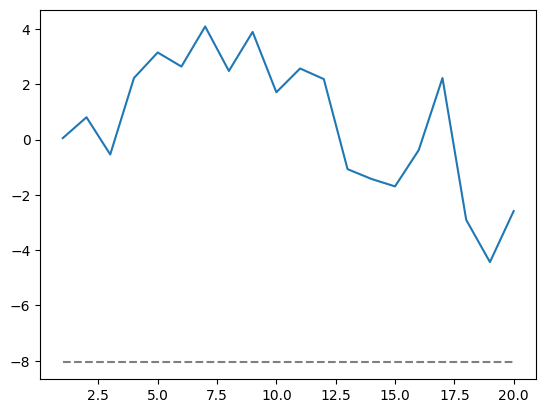

In [15]:
plt.plot(d,ev[0])
E0 = produce_case_parameters(qubits[0])[4]
plt.hlines(E0, 1, 20, 'tab:gray', 'dashed')

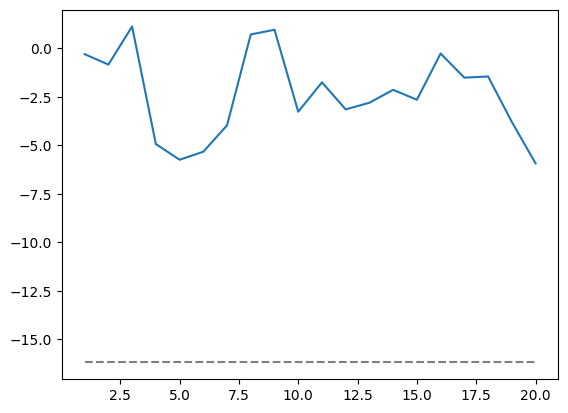

In [18]:
plt.plot(d,ev[1])
E0 = produce_case_parameters(qubits[1])[4]
plt.hlines(E0, 1, 20, 'tab:gray', 'dashed')

In [17]:
d

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])